Python Version: 3.11.4

In [7]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jadriantan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jadriantan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadriantan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Generation

In [8]:
df = pd.read_csv("data.csv", sep=',', on_bad_lines='skip')

/var/folders/z4/sk_p32bx74j8lpnjdx_bmjz80000gn/T/ipykernel_4848/2324558469.py:1: DtypeWarning: Columns (1,7,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", sep=',', on_bad_lines='skip')


In [9]:
# Extract Reviews and Ratings fields
df = df.loc[:, ['review_body', 'star_rating']]
print(df.head())

                                         review_body star_rating
0                                     Great product.           5
1  What's to say about this commodity item except...           5
2    Haven't used yet, but I am sure I will like it.           5
3  Although this was labeled as &#34;new&#34; the...           1
4                    Gorgeous colors and easy to use           4


Convert to binary classification problem:
- Split it into two classes. 
- To avoid biases during model training, I randomly sampled 50,000 reviews from each class. 
- I chose random_state=55 for reproducibility purposes. 
- After sampling, I combined both classes into a balanced dataset.

In [10]:
# Converting into binary classification problem
df['label'] = df['star_rating'].apply(lambda x: 0 if x in [1, 2, 3] else 1)
df['review'] = df['review_body']

# Selecting 50,000 random reviews from each rating class
# Randomizing to avoid biases
df_class_0 = df[df['label'] == 0].sample(n=50000, random_state=55)
df_class_1 = df[df['label'] == 1].sample(n=50000, random_state=55)

# Creating a new df concatenating both classes
balanced_df = pd.concat([df_class_0, df_class_1])

print(balanced_df.head())

                                              review_body star_rating  label  \
98510   These do not work for refill ink it states one...           1      0   
233824  Once the ink cartriges were installed, things ...           3      0   
877033  Nothing special to say here - they are postcar...           3      0   
929541               It is a machine for counting bills.?           1      0   
201881  I guess you get what you pay for.  The magenta...           2      0   

                                                   review  
98510   These do not work for refill ink it states one...  
233824  Once the ink cartriges were installed, things ...  
877033  Nothing special to say here - they are postcar...  
929541               It is a machine for counting bills.?  
201881  I guess you get what you pay for.  The magenta...  


# Data Cleaning

- Convert to Lowercase: This ensures that the same word with different capitalizations is treated uniformly.
- HTML and URL Removal: These elements don't contribute to sentiment.
- Contractions: Expanded contractions, which can be crucial, especially if you're going to tokenize the reviews later on. Expanding contractions helps in maintaining the meaning of the words when tokenized.
- Non-alphabetical Characters Removal: Reduces noise and simplifies the text data.
- Extra Spaces Removal: Removed extra spaces, which can often creep in when you're doing other cleaning tasks.

In [11]:
import contractions

average_len_before = balanced_df['review'].str.len().mean()

# 1)converting all reviews into lowercase. 
# Ensures consistency: "Hello" and "hello" are now the same. 
balanced_df['cleaned_review'] = balanced_df['review'].str.lower()

# 2)removing the HTML and URLs from the reviews
# HTML/URLs don't provide valuable information for sentiment analysis, so we remove them. 
balanced_df['cleaned_review'] = balanced_df['review'].str.replace(r'<.*?>', '', regex=True)
balanced_df['cleaned_review'] = balanced_df['cleaned_review'].str.replace(r'http\S+', '', regex=True)

# 3) Expanding contractions
# We're using the contractions library here to handle a wider range of contractions.
def contractions_helper(ss):
    # To avoid attributionError
    if type(ss) != str: 
        return
    return contractions.fix(ss)

balanced_df['cleaned_review'] = balanced_df['cleaned_review'].apply(contractions_helper)

# 4)removing non-alphabetical characters
# Removing non-alphanum characters since they could be noise in sentiment analysis
balanced_df['cleaned_review'] = balanced_df['cleaned_review'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# 5)removing extra spaces
balanced_df['cleaned_review'] = balanced_df['cleaned_review'].str.replace(r'\s+', ' ', regex=True)

average_len_after = balanced_df['cleaned_review'].str.len().mean()

# average length decreased after cleaning due to the removal of unwanted characters, spaces, and expansion of contractions
print(f'Average length before data cleaning:{average_len_before:.4f}, Average length after data cleaning:{average_len_after:.4f}')



Average length before data cleaning:189.4582, Average length after data cleaning:180.6430


Visualization: common words for positive reviews

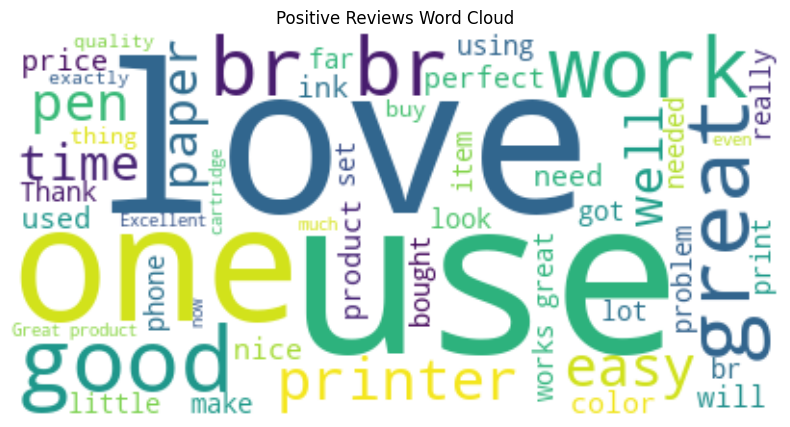

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews in the positive class
text_positive = " ".join(str(review) for review in balanced_df[balanced_df['label'] == 1].review)

# Generate word cloud for positive class
wordcloud_positive = WordCloud(max_words=50, background_color="white").generate(text_positive)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

# Save img to file 
wordcloud_positive.to_file("img/wordcloud_positive.png")


# Preprocessing

Removing stop words

In [13]:
from nltk.corpus import stopwords

# Loading stopwords only once
english_stopwords = set(stopwords.words('english'))
 
def removeStopWords(ss, english_stopwords):
    # Tokenization
    ss = nltk.word_tokenize(ss)

    # Preprocessing stopwords
    ss = [s for s in ss if s not in english_stopwords]

    return ' '.join(ss)

# Filtering out rows where 'review' is not a string
balanced_df = balanced_df[balanced_df['cleaned_review'].apply(lambda x: isinstance(x, str))]

# Removing stopwords in reviews
balanced_df['review_no_stopwords'] = balanced_df['cleaned_review'].apply(lambda x: removeStopWords(x, english_stopwords))

Performing Lemmatization

In [14]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatization(ss):
    ss = nltk.word_tokenize(ss)
    ss = [lemmatizer.lemmatize(s) for s in ss]
    return ' '.join(ss)

balanced_df['review_lemmatized'] = balanced_df['review_no_stopwords'].apply(lemmatization)

print(balanced_df['review_no_stopwords'].head())
print(balanced_df['review_lemmatized'].head())

98510     These work refill ink states one use state any...
233824    Once ink cartriges installed things seem funct...
877033       Nothing special say postcards I got I expected
929541                            It machine counting bills
201881    I guess get pay The magenta cartridge less pri...
Name: review_no_stopwords, dtype: object
98510     These work refill ink state one use state anyw...
233824    Once ink cartriges installed thing seem functi...
877033        Nothing special say postcard I got I expected
929541                             It machine counting bill
201881    I guess get pay The magenta cartridge le print...
Name: review_lemmatized, dtype: object


In [15]:
import pandas as pd

# Create a sample of the data
sample_data = balanced_df.sample(5)

# Initialize the markdown table string
table_string = "| Raw Review | Cleaned Review | Without Stopwords | Lemmatized |\n"
table_string += "|------------|----------------|-------------------|------------|\n"

# Populate the table string with data from the sample
for index, row in sample_data.iterrows():
    # Truncating each column's content to 50 characters for readability
    raw_review = str(row['review'])[:50] + ('...' if len(str(row['review'])) > 50 else '')
    cleaned_review = str(row['cleaned_review'])[:50] + ('...' if len(str(row['cleaned_review'])) > 50 else '')
    no_stopwords = str(row['review_no_stopwords'])[:50] + ('...' if len(str(row['review_no_stopwords'])) > 50 else '')
    lemmatized = str(row['review_lemmatized'])[:50] + ('...' if len(str(row['review_lemmatized'])) > 50 else '')
    
    table_string += f"| {raw_review} | {cleaned_review} | {no_stopwords} | {lemmatized} |\n"

print(table_string)

| Raw Review | Cleaned Review | Without Stopwords | Lemmatized |
|------------|----------------|-------------------|------------|
| This stapler doesn't have any special qualities: i... | This stapler does not have any special qualities i... | This stapler special qualities decent regular stap... | This stapler special quality decent regular staple... |
| Using these to hold our towels right outside our s... | Using these to hold our towels right outside our s... | Using hold towels right outside shower They hold n... | Using hold towel right outside shower They hold ni... |
| Cute.  $ can't beat. | Cute cannot beat | Cute beat | Cute beat |
| I received many Paper Magic cards in the past and ... | I received many Paper Magic cards in the past and ... | I received many Paper Magic cards past I impressed... | I received many Paper Magic card past I impressed ... |
| I agree with everyone. This is a really great pen,... | I agree with everyone This is a really great pen e... | I agree ev

# Feature Extraction:

Bag of Words (BoW): Here, I've used CountVectorizer from the sklearn library to create a BoW representation of the lemmatized reviews, keeping a maximum of 5,000 features.

Term Frequency-Inverse Document Frequency (TF-IDF): I have employed TfidfVectorizer from the sklearn library to transform the lemmatized reviews into TF-IDF features. Again, I'm keeping a maximum of 5,000 features.

Word2Vec: Utilizing the pre-trained Word2Vec model from the Google News dataset (having a dimensionality of 300) and computing the average Word2Vec vectors for each review.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim.downloader as api

Feature: TF-IDF

In [17]:
# Init
tfidf_vector = TfidfVectorizer(max_features=5000)

# Fit and transform reviews to TF-IDF features
tfidf_features = tfidf_vector.fit_transform(balanced_df['review_lemmatized'])

Feature: Word2Vec

In [18]:
# Pre-trained word2vec model
wv_model = api.load('word2vec-google-news-300')

# Calculating the average Word2Vec for each review
def average_word2vec(review, model, dimension):
    avg_w2v = np.zeros((dimension,))
    num_words = 0
    for word in review:
        if word in model:  
            avg_w2v += model[word]
            num_words += 1
    if num_words > 0:
        avg_w2v /= num_words
    return avg_w2v

# Splitting reviews into sentences for Word2Vec
sentences = balanced_df['cleaned_review'].str.split().tolist()

# Convert reviews into feature vectors using average Word2Vec helper function
word2vec_features = np.array([average_word2vec(review, wv_model, 300) for review in sentences])

Training and Testing Split: 80/20

In [19]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_features, 
    balanced_df['label'],
    test_size= 0.2,
    random_state=55
)

x_train_word2vec, x_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    word2vec_features, 
    balanced_df['label'],
    test_size= 0.2,
    random_state=55
)

# Simple Models: Perceptron & SVM 

In [20]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
# Perceptron on tfidf features
tfidf_perceptron = Perceptron(max_iter=1000, random_state=55)

# Fit training set into Perceptron Model 
tfidf_perceptron.fit(x_train_tfidf, y_train_tfidf)

# Make predictions w/ testing set
tfidf_prediction = tfidf_perceptron.predict(x_test_tfidf)

# Report Precision, Recall, and f1-score
tfidf_test_precision = precision_score(y_test_tfidf, tfidf_prediction, average='binary')
tfidf_test_recall = recall_score(y_test_tfidf, tfidf_prediction, average='binary')
tfidf_test_f1 = f1_score(y_test_tfidf, tfidf_prediction, average='binary')

# Print
print(f"TF-IDF Perceptron Model~ Precision:{tfidf_test_precision:.4f}, Recall:{tfidf_test_recall:.4f}, F1-Score:{tfidf_test_f1:.4f}")


# Perceptron on word2vec features
word2vec_perceptron = Perceptron(max_iter=1000, random_state=55)

# Fit training set into Perceptron Model
word2vec_perceptron.fit(x_train_word2vec, y_train_word2vec)

# Make predictions w/ testing set
word2vec_prediction = word2vec_perceptron.predict(x_test_word2vec)

# Report Precision, Recall, and f1-score
word2vec_test_precision = precision_score(y_test_word2vec, word2vec_prediction, average='binary')
word2vec_test_recall = recall_score(y_test_word2vec, word2vec_prediction, average='binary')
word2vec_test_f1 = f1_score(y_test_word2vec, word2vec_prediction, average='binary')

# Print
print(f"Word2Vec Perceptron Model~ Precision:{word2vec_test_precision:.4f}, Recall:{word2vec_test_recall:.4f}, F1-Score:{word2vec_test_f1:.4f}")

TF-IDF Perceptron Model~ Precision:0.8334, Recall:0.7205, F1-Score:0.7729
Word2Vec Perceptron Model~ Precision:0.7218, Recall:0.8902, F1-Score:0.7972


In [22]:
# SVM on tfidf features
tfidf_svm = LinearSVC(dual=False, max_iter=1000, random_state=55)

# Fit training set into SVM classifier 
tfidf_svm.fit(x_train_tfidf, y_train_tfidf)

# Predict on testing set
tfidf_svm_prediction = tfidf_svm.predict(x_test_tfidf)

# Report Precision, Recall, and f1-score
tfidf_svm_precision = precision_score(y_test_tfidf, tfidf_svm_prediction, average='binary')
tfidf_svm_recall = recall_score(y_test_tfidf, tfidf_svm_prediction, average='binary')
tfidf_svm_f1 = f1_score(y_test_tfidf, tfidf_svm_prediction, average='binary')

# Print
print(f"TF-IDF SVM Model~ Precision:{tfidf_svm_precision:.4f} Recall:{tfidf_svm_recall:.4f} F1-Score:{tfidf_svm_f1:.4f}")

# SVM on word2vec features
word2vec_svm = LinearSVC(dual=False, max_iter=1000, random_state=55)

# Fit training set into SVM classifier
word2vec_svm.fit(x_train_word2vec, y_train_word2vec)

# Predict on testing set
word2vec_svm_prediction = word2vec_svm.predict(x_test_word2vec)

# Report Precision, Recall, and f1-score
word2vec_svm_precision = precision_score(y_test_word2vec, word2vec_svm_prediction, average='binary')
word2vec_svm_recall = recall_score(y_test_word2vec, word2vec_svm_prediction, average='binary')
word2vec_svm_f1 = f1_score(y_test_word2vec, word2vec_svm_prediction, average='binary')

# Print
print(f"Word2Vec SVM Model~ Precision:{word2vec_svm_precision:.4f} Recall:{word2vec_svm_recall:.4f} F1-Score:{word2vec_svm_f1:.4f}")

TF-IDF SVM Model~ Precision:0.8510 Recall:0.8380 F1-Score:0.8445
Word2Vec SVM Model~ Precision:0.8648 Recall:0.7749 F1-Score:0.8174


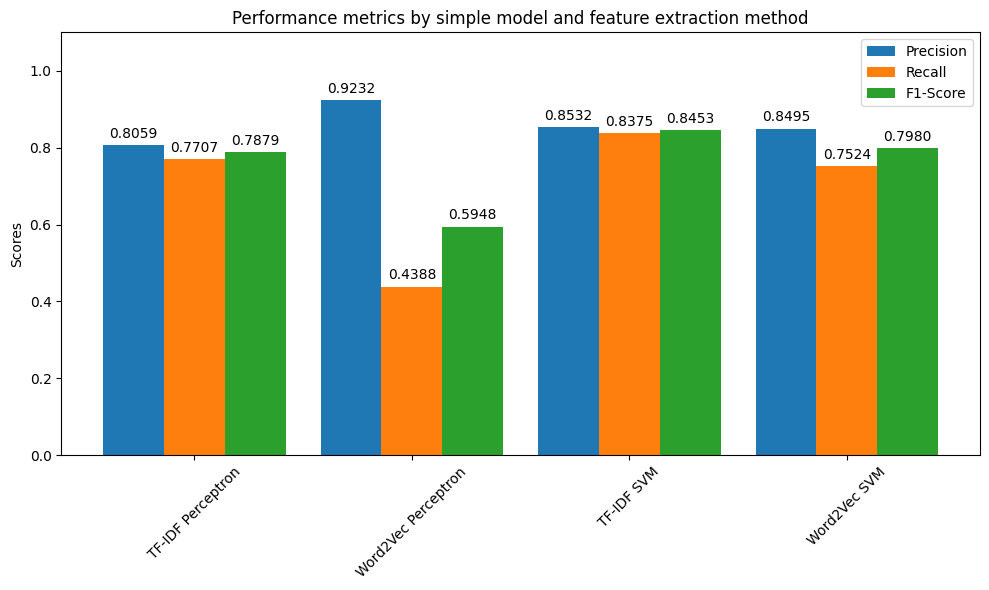

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
labels = ['TF-IDF Perceptron', 'Word2Vec Perceptron', 'TF-IDF SVM', 'Word2Vec SVM']

precision = [0.8059, 0.9232, 0.8532, 0.8495]
recall = [0.7707, 0.4388, 0.8375, 0.7524]
f1_score = [0.7879, 0.5948, 0.8453, 0.7980]

x = np.arange(len(labels))
width = 0.28  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Performance metrics by simple model and feature extraction method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adjust the y-axis maximum value
ax.set_ylim(0, 1.1)  # Here's the added line to set the y-axis limits

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Function to auto-label the bars with their values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

# Save img to file
fig.savefig('img/simple_model_performance_metrics.png')


# Recurrent Neural Network: Simple RNN, GRU, LSTM

In [24]:
# Maintain the sequence of vectors since RNN processes inputs one step at a time and maintains a hidden state across those steps
def get_word2vec_sequence(review, model, dimension):
    w2v_sequence = []
    for word in review:
        if word in model:
            w2v_sequence.append(model[word])
        else:
            w2v_sequence.append(np.zeros((dimension,)))  # Using a zero vector for unknown words
    return w2v_sequence

# Convert reviews into sequences of Word2Vec vectors
sentences = balanced_df['cleaned_review'].str.split().tolist()
word2vec_sequences = [get_word2vec_sequence(review, wv_model, 300) for review in sentences]

# To feed your data into our RNN, limit the maximum review length to 10 
# by truncating longer reviews and padding shorter reviews with a null value (0)
def pad_or_truncate_sequence(sequence, max_length):
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        while len(sequence) < max_length:
            sequence.append(np.zeros((300,)))  # Padding with zero vectors
    return sequence

padded_word2vec_sequences = np.array([pad_or_truncate_sequence(seq, 10) for seq in word2vec_sequences])

In [25]:
# Split into train and test sets using padded_word2vec_sequences
x_train_word2vec, x_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    padded_word2vec_sequences, 
    balanced_df['label'],
    test_size= 0.2,
    random_state=55
)

In [26]:
# Hyperparameters: one hidden layer with 10
input_size = 300  
hidden_size = 10
output_size = 2

model_list = []
accuracies = []

### Simple RNN

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [28]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Only take the last time step's output for classification
        return out
  
model = SimpleRNN(input_size, hidden_size, output_size)

# Convert to PyTorch tensors
x_train_rnn_tensor = torch.FloatTensor(x_train_word2vec)
x_test_rnn_tensor = torch.FloatTensor(x_test_word2vec)
y_train_rnn_tensor = torch.LongTensor(y_train_word2vec.values)
y_test_rnn_tensor = torch.LongTensor(y_test_word2vec.values)

# Create train loader with batch size 64
train_data_rnn = TensorDataset(x_train_rnn_tensor, y_train_rnn_tensor)
train_loader_rnn = DataLoader(train_data_rnn, batch_size=64, shuffle=True)

# Initialize loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
for epoch in range(epochs):
    for _, (data, target) in enumerate(train_loader_rnn):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

with torch.no_grad():
    test_outputs = model(x_test_rnn_tensor)
    _, predicted = test_outputs.max(1)
    accuracy = (predicted == y_test_rnn_tensor).sum().item() / len(y_test_word2vec)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Append to lists for performance metric
model_list.append("Simple RNN")
accuracies.append(accuracy)

Epoch 1/10, Loss: 0.5251815915107727
Epoch 2/10, Loss: 0.49477580189704895
Epoch 3/10, Loss: 0.3801306188106537
Epoch 4/10, Loss: 0.6687284708023071
Epoch 5/10, Loss: 0.4444862902164459
Epoch 6/10, Loss: 0.3909308612346649
Epoch 7/10, Loss: 0.4460638761520386
Epoch 8/10, Loss: 0.3797049820423126
Epoch 9/10, Loss: 0.5193456411361694
Epoch 10/10, Loss: 0.506540834903717
Test Accuracy: 77.14%


## GRU

In [29]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGRU, self).__init__()
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # NOTE: Only taking the last time step's output for classification
        return out

# Initialize model, loss, and optimizer
model = SimpleGRU(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  

# Training
epochs = 10
for epoch in range(epochs):
    for _, (data, target) in enumerate(train_loader_rnn):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Testing
with torch.no_grad():
    test_outputs = model(x_test_rnn_tensor)
    _, predicted = test_outputs.max(1)
    accuracy = (predicted == y_test_rnn_tensor).sum().item() / len(y_test_word2vec)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Append to lists for performance metric
model_list.append("GRU")
accuracies.append(accuracy)

Epoch 1/10, Loss: 0.36886149644851685
Epoch 2/10, Loss: 0.3315728008747101
Epoch 3/10, Loss: 0.2716361880302429
Epoch 4/10, Loss: 0.40819624066352844
Epoch 5/10, Loss: 0.4312066435813904
Epoch 6/10, Loss: 0.21302074193954468
Epoch 7/10, Loss: 0.40373435616493225
Epoch 8/10, Loss: 0.29426029324531555
Epoch 9/10, Loss: 0.2596054673194885
Epoch 10/10, Loss: 0.23394185304641724
Test Accuracy: 83.85%


## LSTM

In [30]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        
        # Using LSTM instead of GRU
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize both hidden state and cell state for LSTM
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Only take the last time step's output for classification
        return out

# Model, Criterion, Optimizer Initialization
model = SimpleLSTM(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
epochs = 10
for epoch in range(epochs):
    for _, (data, target) in enumerate(train_loader_rnn):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Testing
with torch.no_grad():
    test_outputs = model(x_test_rnn_tensor)
    _, predicted = test_outputs.max(1)
    accuracy = (predicted == y_test_rnn_tensor).sum().item() / len(y_test_word2vec)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Append to lists for performance metric
model_list.append("LSTM")
accuracies.append(accuracy)

Epoch 1/10, Loss: 0.43067190051078796
Epoch 2/10, Loss: 0.28986695408821106
Epoch 3/10, Loss: 0.2952951490879059
Epoch 4/10, Loss: 0.3217526972293854
Epoch 5/10, Loss: 0.4516555368900299
Epoch 6/10, Loss: 0.38306814432144165
Epoch 7/10, Loss: 0.35195568203926086
Epoch 8/10, Loss: 0.36780595779418945
Epoch 9/10, Loss: 0.2843724489212036
Epoch 10/10, Loss: 0.32746365666389465
Test Accuracy: 83.28%


## Performance Metrics for RNN 

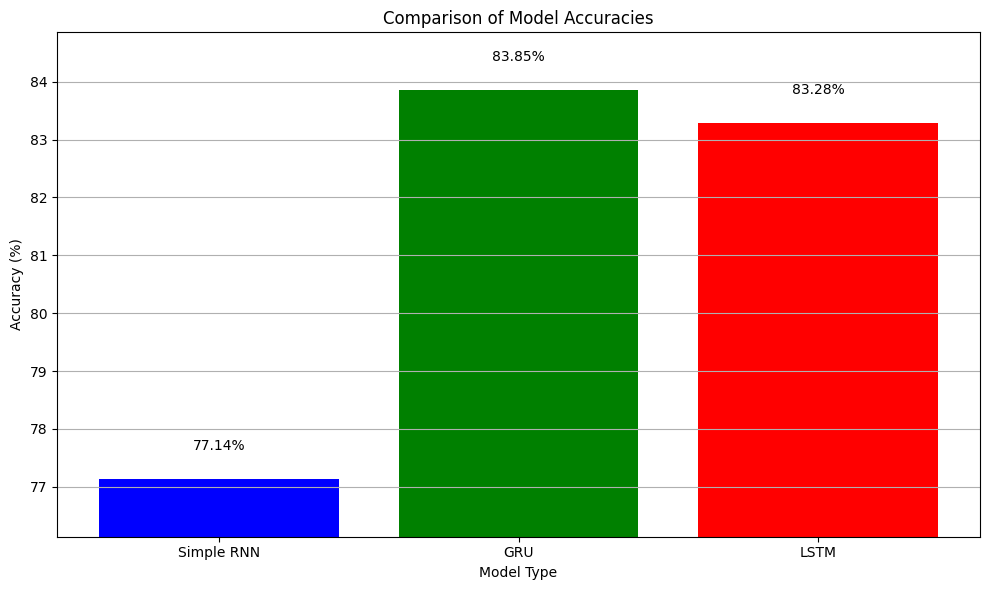

In [32]:
import matplotlib.pyplot as plt

# Data to visualize
models = ['Simple RNN', 'GRU', 'LSTM']
accuracy_percentage = [acc * 100 for acc in accuracies]

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(models, accuracy_percentage, color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([min(accuracy_percentage) - 1, max(accuracy_percentage) + 1])  # Adjusting y-axis to better visualize differences
plt.grid(axis='y')

# Displaying the accuracy values on top of the bars
for i, v in enumerate(accuracy_percentage):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')

# Show the plot
plt.tight_layout()
plt.savefig('img/rnn_metrics.png')
plt.show()


